In [5]:
# Import package dependencies
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm

import sklearn
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import altair as alt
from ml_metrics import rmse

# Abstract

# Introduction

While in an ideal world all datasets would be complete, in the real world datasets often have some missing data fields. There are countless reasons for the the existence of missing data but for the most part missing data falls into one of three catergories:

Missing completely at random (MCAR) - No reason why, totally random.
Missing at random (MAR) - Typically missing only in a subset of data – the subset of data is determined by another value, but within the subset the data is randomly missing.
Not missing at random (NMAR) - There is a definite pattern to the missing data.

In the case of MCAR and and MAR, deletion of the missing values through listwise or pairwise methods can be employed, however this can present some problems. In the case of listwise deletion the resulting data set will be smaller a reduce the power of statistical tests, deletion of too many records may lead to an inaccurate representation of the data, and if the missing data is MNAR deletion of the records may obscure the presence of a systematic problem and result in biased results. In the case of pairwise deletion, the resulting dataset can lead to parameters based on different standard errors, result in measures of mean and standard for fields with a different number of observations, affect the sample sizes used for calculating correlation. All these issues can create computational problems for certain statistical analysis methods. One alternative to the deletion of missing values is assingning a value to the missing fields through imputation. However as with deletion, imputation can affect the characteristics of the dataset and bias the results of statistical computations. 

This project will evaluate the efficacy of deletion and imputation as solutions to missing data. We will use a complete data set, the Boston Housing dataset, to test various methods and determine the method that results in a model that best captures the characteristics of the original dataset. We will accomplish this by first fitting a linear model to the full Boston housing dataset and caluclating the goodness of fit prameters for the dataset, that will act as our baseline and control. We will then create 6 new datasets by randomly removing 1%, 5%, 10%, 20%, 33% and 50% of the observations in a single column from the full dataset. We will then then fit each of the missing value datasets using pairwise deletion and different imputation methods and calculate the goodness of fit for each method of dealing with missing data for each level of missing data to determine the efficacy of each method given each condition.         


# Data

In [6]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [7]:
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [8]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [9]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [13]:
bos_df = pd.DataFrame(boston.data)
bos_df.columns = boston.feature_names
print(bos_df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  


In [15]:
bos_df['PRICE'] = boston.target
print(bos_df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


# Exploratory Data Analysis

In [47]:
print(bos_df.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

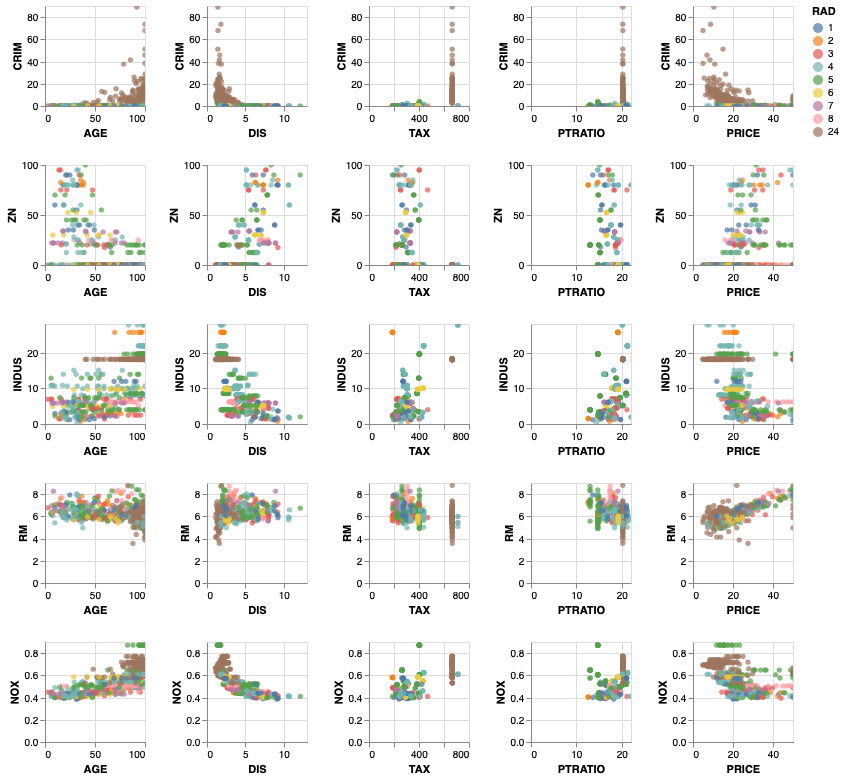

In [28]:
source = bos_df

alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='RAD:N'
).properties(
    width=100,
    height=100
).repeat(
    row=['CRIM', 'ZN', 'INDUS', 'RM', 'NOX'],
    column=['AGE', 'DIS', 'TAX', 'PTRATIO','PRICE']
).interactive()

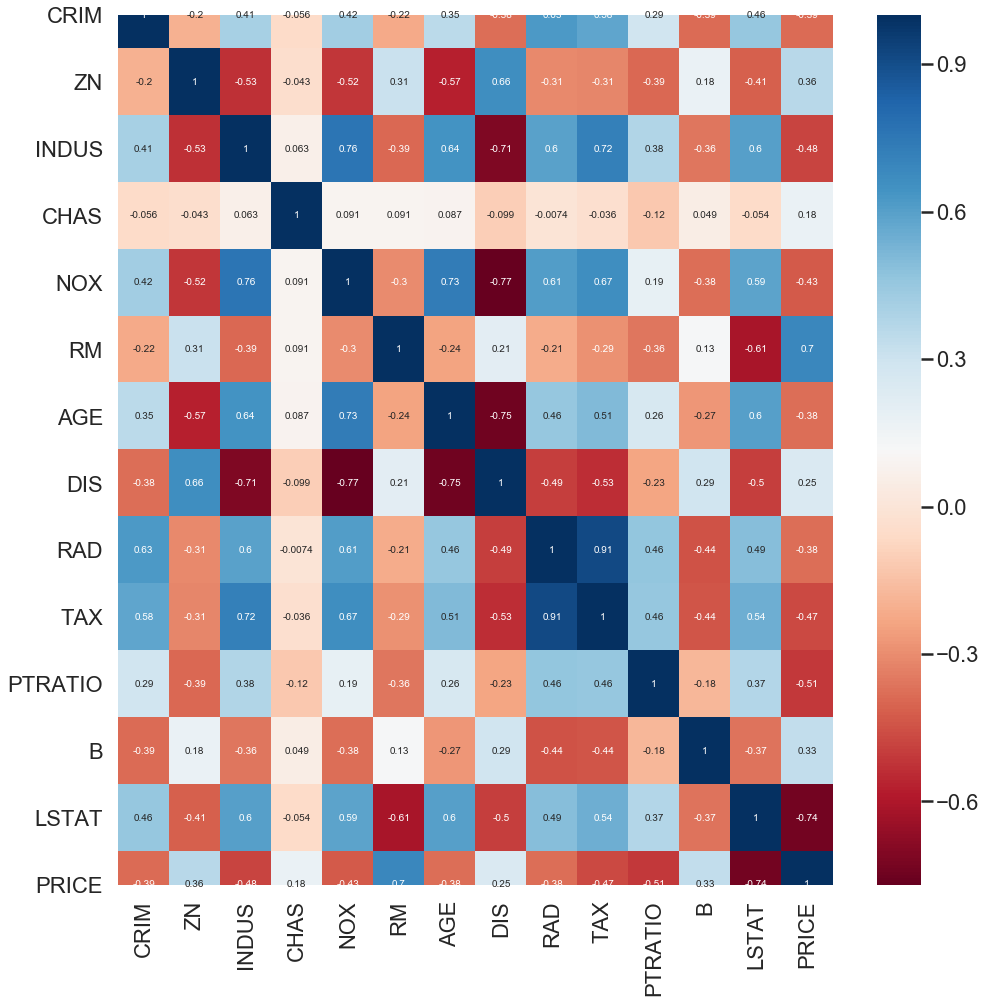

In [37]:
ax, fig = plt.subplots(figsize = (16,16))
sns.heatmap(bos_df.corr(), annot=True, cmap = 'RdBu') 
plt.show()

In [40]:
print('DataFrame Null values:' , bos_df.isnull().values.ravel().sum())
print('Number of unique classes:\n',bos_df.nunique())

DataFrame Null values: 0
Number of unique classes:
 CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
PRICE      229
dtype: int64


In [53]:
def normal_equation(x,y):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T),y)

features = ['LSTAT', 'RM']
X_b = np.c_[np.ones((len(bos_df[features]),1)), bos_df[features].values] #X matrix
X_b.shape

(506, 3)

In [111]:
from sklearn.model_selection import train_test_split

#test-train - X = All other features & Y = Boston Housing Price

X = bos_df.drop('PRICE', axis = 1)
Y = bos_df['PRICE']

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_b, Y, test_size = 0.20, random_state = 10)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(404, 3)
(102, 3)
(404,)
(102,)


In [112]:
theta1 = normal_equation(X_train1, Y_train1)
theta1

array([ 3.14487154, -0.68480439,  4.43045078])

In [113]:
pred1 = np.dot(X_train1, theta1)

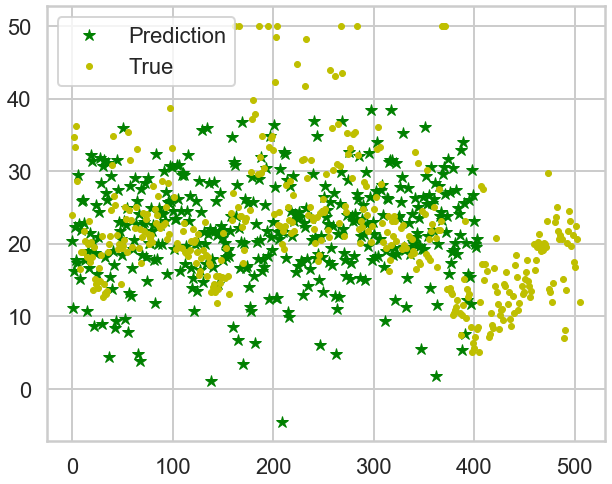

In [114]:
ax, fig = plt.subplots(figsize = (10,8))
plt.plot(pred1, 'g.', marker = '*')
plt.plot(Y_train1, 'y.')
plt.legend(['Prediction', 'True'])
plt.show()

In [115]:
from sklearn.metrics import mean_squared_error
mse_train = sklearn.metrics.mean_squared_error(pred1, Y_train1)
print(mse_train)

27.987941185479475


In [116]:
test_pred1 = np.dot(X_test1, theta1)

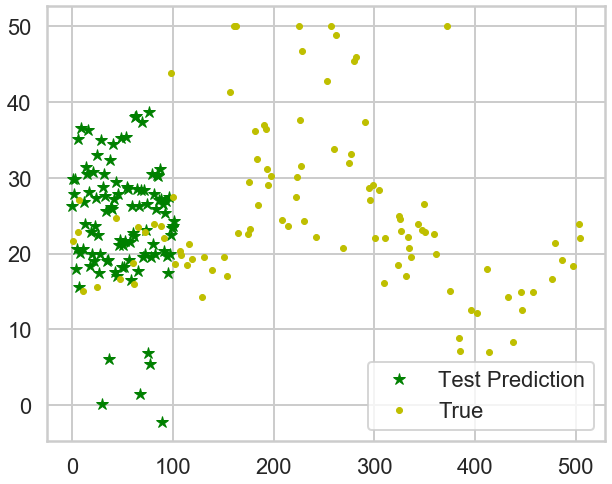

In [117]:
ax, fig = plt.subplots(figsize = (10,8))
plt.plot(test_pred1, 'g.', marker = '*')
plt.plot(Y_test1, 'y.')
plt.legend(['Test Prediction', 'True'])
plt.show()

In [118]:
mse_test = sklearn.metrics.mean_squared_error(test_pred1, Y_test1)
print(mse_test)

41.40202341152446


In [119]:
lm = LinearRegression()
lm.fit(X_train1, Y_train1)

Y_pred1 = lm.predict(X_test1)

In [120]:
mse = sklearn.metrics.mean_squared_error(Y_test1, Y_pred1)
print(mse)

41.402023411523814


In [83]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.30, random_state = 10)

#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

#X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.55, random_state = 25)

#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

#X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.15, random_state = 50)

#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

#X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.05, random_state = 50)

#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

#X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.01, random_state = 50)

#print(X_train.shape)
#print(X_test.shape)
#print(Y_train.shape)
#print(Y_test.shape)

(102,)
